In [1]:
import os
import sys
import argparse
import numpy as np
import numba as nb
import scipy.stats
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from tools import merge_matrix, hic_norm, clean_matrix

@nb.jit()
def down_sample_but_same_size(matrix, ratio):
    dim = matrix.shape
    _l = int(dim[0]/ratio)
    _m = np.zeros((dim[0], dim[0]))
    for i in range(_l):
        for j in range(_l):
            _m[i*ratio:(i+1)*ratio, j*ratio:(j+1)*ratio] = matrix[i*ratio:(i+1)*ratio, j*ratio:(j+1)*ratio].mean()
    return _m

In [2]:
hr_path = '/data1/lmh_data/MMSR_complete/train/hr/chr19_1000b.npz'
complete_enhanced_path = '/data1/lmh_data/lab/train/validation/chr19_1kb.npz'
low5_enhanced_path = '/data1/lmh_data/MMSR_complete/analyse/low/low5/low5_result.npz'
low10_enhanced_path = '/data1/lmh_data/MMSR_complete/analyse/low/low10/low10_result.npz'

In [3]:
hr = np.load(hr_path)['hic'].astype(float)
complete_enhanced = np.load(complete_enhanced_path)['out'].astype(float)
low5_enhanced = np.load(low5_enhanced_path)['out'].astype(float)
low10_enhanced = np.load(low10_enhanced_path)['out'].astype(float)

In [4]:
print(hr.shape)
print(complete_enhanced.shape)
print(low5_enhanced.shape)
print(low10_enhanced.shape)

(147, 5, 400, 400)
(147, 5, 400, 400)
(147, 5, 400, 400)
(147, 5, 400, 400)


In [5]:
for i in range(complete_enhanced.shape[0]):
    complete_enhanced[i][0] = (complete_enhanced[i][0] + complete_enhanced[i][0].T)/2
    low5_enhanced[i][0] = (low5_enhanced[i][0] + low5_enhanced[i][0].T)/2
    low10_enhanced[i][0] = (low10_enhanced[i][0] + low10_enhanced[i][0].T)/2

matrixs = [hr, complete_enhanced, low5_enhanced, low10_enhanced]
for i in range(0, len(matrixs)):
    matrixs[i] = merge_matrix(matrixs[i])
    matrixs[i] = np.triu(matrixs[i]).T + np.triu(matrixs[i])

matrixs[0] = hic_norm(matrixs[0])

matrixs, Min = clean_matrix(matrixs)

In [6]:
@nb.jit()
def down_sample(matrix, ratio):
    dim = matrix.shape
    _l = int(dim[0]/ratio)
    _m = np.zeros((_l, _l))
    for i in range(_l):
        for j in range(_l):
            _m[i, j] = matrix[i*ratio:(i+1)*ratio, j*ratio:(j+1)*ratio].mean()
    return _m

down_matrixs = []
for i in range(len(matrixs)):
    down_matrixs.append(down_sample(matrixs[i], 10))

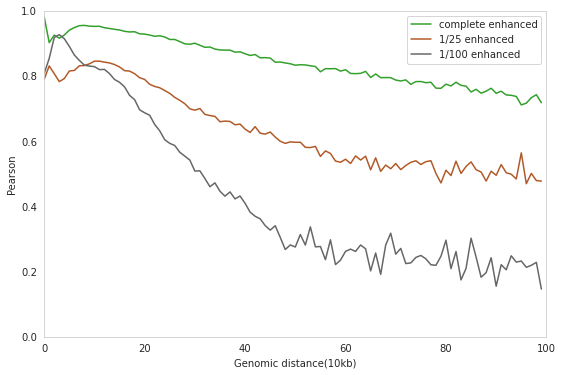

complete_enhanced: 0.8436130129459479
low5_enhanced: 0.6312347829925236
low10_enhanced: 0.427032484388135


In [11]:
# fig5: 10kb PCC
chrom = 19
distance_all = [[0, chrom]]
dic_norm = {}
length = 100 # 1mb
for i in range(length):
    dic_norm[i]=[[], [], [], []]
for i in range(len(distance_all)):
    for j in range(-length+1, length, 1):
        dis = distance_all[i][0] - j
        for k in range(len(matrixs)):
            dic_norm[abs(dis)][k]+=down_matrixs[k].diagonal(offset=j).tolist()

complete_enhanced_y, low5_enhanced_y, low10_enhanced_y = [], [], []
for i in range(length):
    complete_enhanced_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][1])[0])
    low5_enhanced_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][2])[0])
    low10_enhanced_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][3])[0])

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 6), sharey=True)
axes.grid(False)
axes.plot(list(range(length)), complete_enhanced_y, color=(51/255, 160/255, 44/255), label='complete enhanced')
axes.plot(list(range(length)), low5_enhanced_y, color=(177/255, 89/255, 40/255), label='1/25 enhanced')
axes.plot(list(range(length)), low10_enhanced_y, color=(102/255, 102/255, 102/255), label='1/100 enhanced')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(10kb)')
plt.ylabel('Pearson')
plt.xlim(0, 100)
plt.legend()
plt.savefig('fig/fig5_10kb_PCC.pdf')
plt.show()

print("complete_enhanced: {}".format(np.mean(complete_enhanced_y)))
print("low5_enhanced: {}".format(np.mean(low5_enhanced_y)))
print("low10_enhanced: {}".format(np.mean(low10_enhanced_y)))

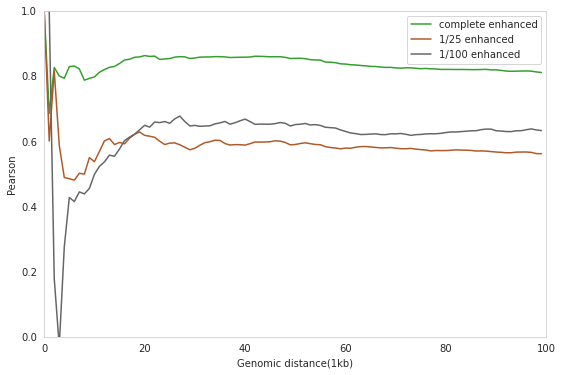

complete_enhanced: 0.8355758276880338
low5_enhanced: 0.5856774251188704
low10_enhanced: 0.6150238702389061


In [12]:
# fig5: 1kb PCC
@nb.jit(nopython=True)
def make_PCCscore(matrix1, matrix2, begin, radius):
    scores = []
    for i in range(0, radius):
        _s = np.corrcoef(matrix1[begin-i:begin+i, begin-i:begin+i].flatten(), matrix2[begin-i:begin+i, begin-i:begin+i].flatten())[0, 1]
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_enhanced_y = make_PCCscore(matrixs[0], matrixs[1], begin, radius)
low5_enhanced_y = make_PCCscore(matrixs[0], matrixs[2], begin, radius)
low10_enhanced_y = make_PCCscore(matrixs[0], matrixs[3], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 6), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_enhanced_y, color=(51/255, 160/255, 44/255), label='complete enhanced')
axes.plot(list(range(radius)), low5_enhanced_y, color=(177/255, 89/255, 40/255), label='1/25 enhanced')
axes.plot(list(range(radius)), low10_enhanced_y, color=(102/255, 102/255, 102/255), label='1/100 enhanced')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('Pearson')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig5_1kb_PCC.pdf')
plt.show()

print("complete_enhanced: {}".format(np.mean(complete_enhanced_y)))
print("low5_enhanced: {}".format(np.mean(low5_enhanced_y)))
print("low10_enhanced: {}".format(np.mean(low10_enhanced_y)))

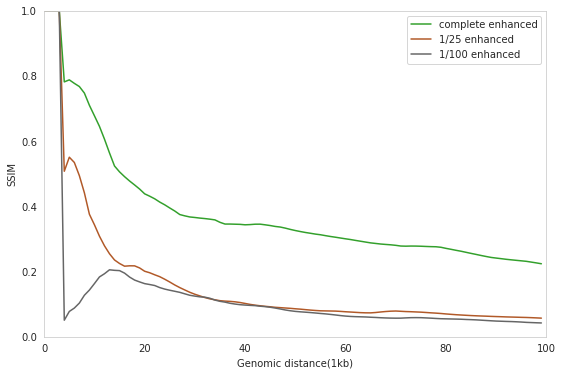

complete_enhanced: 0.38649388831883924
low5_enhanced: 0.16779557907758808
low10_enhanced: 0.12814217751316148


In [13]:
# fig5: 1kb ssim
# @nb.jit(nopython=True)
def make_SSIMscore(matrix1, matrix2, begin, radius):
    scores = [1]*4
    for i in range(4, radius):
        _s = structural_similarity(matrix1[begin-i:begin+i, begin-i:begin+i], matrix2[begin-i:begin+i, begin-i:begin+i])
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_enhanced_y = make_SSIMscore(matrixs[0], matrixs[1], begin, radius)
low5_enhanced_y = make_SSIMscore(matrixs[0], matrixs[2], begin, radius)
low10_enhanced_y = make_SSIMscore(matrixs[0], matrixs[3], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 6), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_enhanced_y, color=(51/255, 160/255, 44/255), label='complete enhanced')
axes.plot(list(range(radius)), low5_enhanced_y, color=(177/255, 89/255, 40/255), label='1/25 enhanced')
axes.plot(list(range(radius)), low10_enhanced_y, color=(102/255, 102/255, 102/255), label='1/100 enhanced')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('SSIM')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig5_1kb_SSIM.pdf')
plt.show()

print("complete_enhanced: {}".format(np.mean(complete_enhanced_y)))
print("low5_enhanced: {}".format(np.mean(low5_enhanced_y)))
print("low10_enhanced: {}".format(np.mean(low10_enhanced_y)))

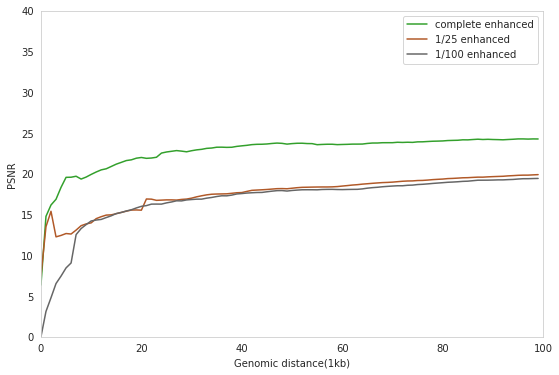

complete_enhanced: 22.677886956649953
low5_enhanced: 17.530372964484087
low10_enhanced: 16.745106737378595


In [14]:
# fig5: 1kb psnr
# @nb.jit(nopython=True)
def make_PSNRscore(matrix1, matrix2, begin, radius):
    scores = []
    for i in range(0, radius):
        _m1 = matrix1[begin-i:begin+i+1, begin-i:begin+i+1]
        _m2 = matrix2[begin-i:begin+i+1, begin-i:begin+i+1]
        _range = max(_m1.max(), _m2.max())
        _s = peak_signal_noise_ratio(_m1, _m2, data_range=_range)
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_enhanced_y = make_PSNRscore(matrixs[0], matrixs[1], begin, radius)
low5_enhanced_y = make_PSNRscore(matrixs[0], matrixs[2], begin, radius)
low10_enhanced_y = make_PSNRscore(matrixs[0], matrixs[3], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 6), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_enhanced_y, color=(51/255, 160/255, 44/255), label='complete enhanced')
axes.plot(list(range(radius)), low5_enhanced_y, color=(177/255, 89/255, 40/255), label='1/25 enhanced')
axes.plot(list(range(radius)), low10_enhanced_y, color=(102/255, 102/255, 102/255), label='1/100 enhanced')

plt.ylim(0, 40)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('PSNR')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig5_1kb_PSNR.pdf')
plt.show()

print("complete_enhanced: {}".format(np.mean(complete_enhanced_y)))
print("low5_enhanced: {}".format(np.mean(low5_enhanced_y)))
print("low10_enhanced: {}".format(np.mean(low10_enhanced_y)))